In [1]:
import autogen
from opto.trace.nodes import node, GRAPH
import string
import random
import numpy as np
from textwrap import dedent
from opto.optimizers import FunctionOptimizer

from typing import List
import copy
from opto.trace.bundles import FunModule, bundle, trace_class, TraceExecutionError
from opto.trace.nodes import Node

import io, contextlib
import sys
import time
import resource
import itertools
from itertools import accumulate, product, permutations, combinations
import collections
from collections import Counter, OrderedDict, deque, defaultdict, ChainMap
from functools import lru_cache
import math
from math import sqrt, sin, cos, tan, ceil, fabs, floor, gcd, exp, log, log2
import fractions
from typing import List, Tuple
import numpy as np
import random
import heapq

In [10]:
@trace_class
class CodingAgent:

    @bundle(description="[atom] Numbers become numbers; every other token is a symbol.", trainable=True)
    def atom(self, token):
        return token

    @bundle(
        description="[test_atom] Test the functionality of another function self.atom(token). "
        + "self.atom: Numbers become numbers; every other token is a symbol. "
        + "Return True/False to show whether the test passes or not, and only one pair of test_input and expected_output. Not a list.",
        trainable=True,
    )
    def test_atom(self):
        test_token = ")"
        expected_output = ")"
        if self.atom(test_token) == ")":
            return True, self.atom(test_token), expected_output
        else:
            return False, test_token, expected_output

    def true_test_atom(self):
        # return test inputs, and expected outputs
        return ["1", "a", "1.2"], [1, "a", 1.2]

In [11]:
agent = CodingAgent()
obs = node(")", trainable=False)
agent.atom(obs).data


def user_fb_for_true_test(expected_output, output):
    try:
        assert expected_output == output, f"Test failed with expected output={expected_output} but got output={output}"
        reward = 1
    except Exception as e:
        return 0, str(e)

    return reward, f"Passed one test with expected output={expected_output} and output={output}."

In [27]:
decision, test_token, expected_output = agent.test_atom()

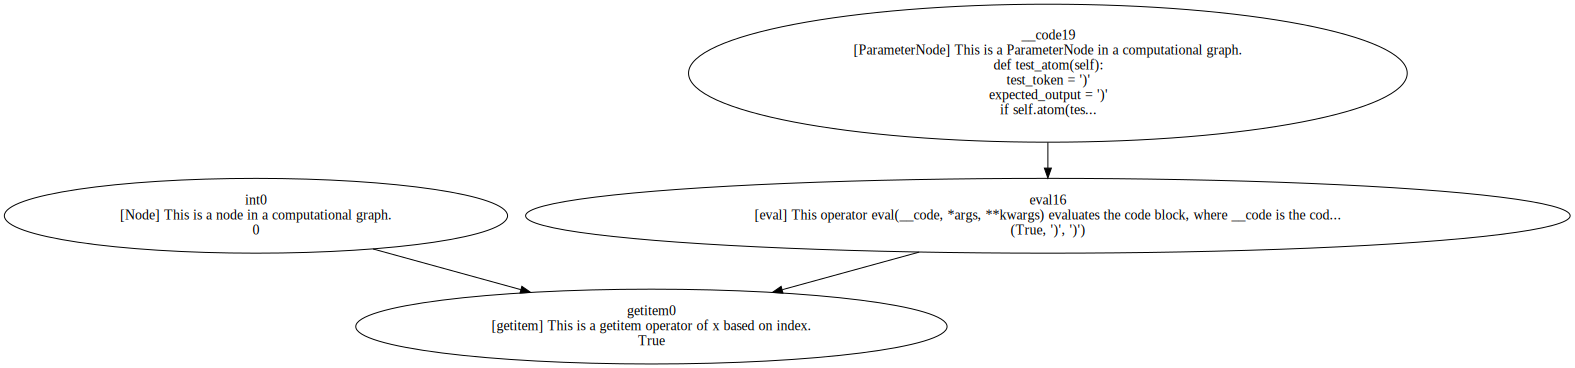

In [29]:
decision.backward(visualize=True)

In [4]:
def optimize_function(optimizer, output, reward, feedback):
    print("====Optimize function====")
    hint = f"We write code that passes the unit tests."
    optimizer.objective = f"{optimizer.default_objective} Hint: {hint}"

    optimizer.zero_feedback()
    optimizer.backward(output, feedback)

    print(f"output={output.data}, feedback={feedback}, variables=\n")  # logging
    optimizer.step(verbose=False)

    for p in optimizer.parameters:
        print(p.name, p.data)

First half: self-optimization loop

In [5]:
GRAPH.clear()

agent = CodingAgent()
optimizer = FunctionOptimizer(
    [agent.parameters_dict()["atom"]], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST")
)
test_optimizer = FunctionOptimizer(
    [agent.parameters_dict()["test_atom"]], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST")
)

feedback = ""
terminal = False

max_calls = 1


while not terminal and max_calls > 0:
    # we first start with test code, if pass, we evaluate the agent's actual function
    self_test_pass = False
    max_self_test_time = 3

    while not self_test_pass and max_self_test_time > 0:
        try:
            test_decision, test_token, test_expected_output = agent.test_atom()
            self_test_pass = test_decision.data

            if not self_test_pass:
                test_output = agent.atom(test_token)
                reward, feedback = user_fb_for_true_test(test_expected_output, test_output)
                optimize_function(optimizer, test_output, reward, feedback)

        except TraceExecutionError as e:
            test_decision = e.exception_node
            self_test_pass = False
            # we only optimize if the test code is broken here
            # if it's not broken, we optimize
            hint = f"The current unit test code should not have any exception. Can use try/catch block. The returned output must be True/False."
            test_optimizer.objective = f"{optimizer.default_objective} Hint: {hint}"
            test_optimizer.zero_feedback()
            test_optimizer.backward(test_decision, test_decision.data)

            print("==== Test function optimization ====")
            print(f"feedback={test_decision.data}, variables=\n")  # logging
            for p in test_optimizer.parameters:
                print(p.name, p.data)
            test_optimizer.step(verbose=False)

        print(f"Test status: Pass={self_test_pass}")
        max_self_test_time -= 1

    max_calls -= 1

Test status: Pass=True


This one has self-improvement in-mind, but that requires producing test cases, which I don't know how to best do.

In [12]:
GRAPH.clear()

agent = CodingAgent()
optimizer = FunctionOptimizer(
    [agent.parameters_dict()["atom"]], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST")
)
test_optimizer = FunctionOptimizer(
    [agent.parameters_dict()["test_atom"]], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST")
)

feedback = ""
terminal = False

max_calls = 3


while not terminal and max_calls > 0:
    # we first start with test code, if pass, we evaluate the agent's actual function
    self_test_pass = False
    max_self_test_time = 3

    while not self_test_pass and max_self_test_time > 0:
        try:
            test_decision, test_token, test_expected_output = agent.test_atom()
            self_test_pass = test_decision.data
            exception = False

            if not self_test_pass:
                test_output = agent.atom(test_token)
                reward, feedback = user_fb_for_true_test(test_expected_output.data, test_output.data)
                optimize_function(optimizer, test_output, reward, feedback)

        except TraceExecutionError as e:
            test_decision = e.exception_node
            feedback = test_decision.data
            self_test_pass = False
            exception = True
        except Exception as e:
            test_decision = agent.test_atom()
            self_test_pass = False
            feedback = str(e)
            exception = True

        # we only optimize if the test code is broken here
        # if it's not broken, we optimize
        if exception:
            hint = f"The current unit test code should not have any exception. Can use try/catch block. The returned output must be True/False."
            test_optimizer.objective = f"{optimizer.default_objective} Hint: {hint}"
            test_optimizer.zero_feedback()
            test_optimizer.backward(test_decision, feedback)

            print("==== Test function optimization ====")
            print(f"feedback={test_decision.data}, variables=\n")  # logging
            for p in test_optimizer.parameters:
                print(p.name, p.data)
            test_optimizer.step(verbose=False)

        print(f"Test status: Pass={self_test_pass}")
        max_self_test_time -= 1

    # second half, actual function checking and optimization
    test_cases = agent.true_test_atom()
    total_reward = 0
    full_feedback = ""
    for test_input, expected_output in zip(test_cases[0], test_cases[1]):
        try:
            output = agent.atom(test_input)
            reward, feedback = user_fb_for_true_test(expected_output, output.data)
            total_reward += reward
        except TraceExecutionError as e:
            # this is essentially a retry
            output = e.exception_node
            feedback = e.exception_node.data

        full_feedback += feedback + "\n"

    # optimize the code function
    hint = f"The current code passed {reward*100}% of the unit tests. We write code that passes all the unit tests."
    optimizer.objective = f"{optimizer.default_objective} Hint: {hint}"

    reward = total_reward / len(agent.true_test_atom()[0])
    terminal = reward == 1  # pass rate

    print("reward:", reward)

    optimize_function(optimizer, output, reward, full_feedback)

    # optimize the test function
    # if our function didn't pass, then the test function needs to be optimized
    if not terminal:
        test_reward = 0
        hint = f"Write more thorough tests and give better test input/outputs!"
        test_optimizer.objective = f"{test_optimizer.default_objective} Hint: {hint}"
        test_optimizer.zero_feedback()
        test_optimizer.backward(
            test_decision,
            "The current test function found no error. However, the actual function did not pass the real unit tests. Write more thorough tests and give better test input/outputs!",
        )

        print("==== Test function optimization ====")
        print(f"feedback={test_decision.data}, variables=\n")  # logging
        test_optimizer.step(verbose=False)
        for p in test_optimizer.parameters:
            print(p.name, p.data)

    max_calls -= 1

Test status: Pass=True
reward: 0.3333333333333333
====Optimize function====
output=1.2, feedback=Test failed with expected output=1 but got output=1
Passed one test with expected output=a and output=a.
Test failed with expected output=1.2 but got output=1.2
, variables=

__code:0 def atom(self, token):
    try:
        if '.' in token:
            return float(token)
        else:
            return int(token)
    except ValueError:
        return token

==== Test function optimization ====
feedback=True, variables=

__code:1 def test_atom(self):
    test_scenarios = [
        (')', ')'),
        ('(', '('),
        ('[', '['),
        (']', ']'),
        ('?', None)
    ]
    results = []
    for test_token, expected in test_scenarios:
        result = self.atom(test_token) == expected
        results.append((result, self.atom(test_token), expected))
    return results
==== Test function optimization ====
feedback=[(True, <opto.trace.nodes.MessageNode object at 0x7f13784e6e80>, ')'), 

This one does not have self-improvement